In [33]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import os



In [34]:
current_directory = os.getcwd()
print(current_directory)

BATCH_SIZE =128
IMAGE_SIZE = 256
EPOCHS = 50

/Users/bhargobdeka/Desktop/Projects/Generate-Images-Houseplants/Training


Found 1014 files belonging to 2 classes.


2023-10-25 14:48:08.952179: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 607 of 1024
2023-10-25 14:48:14.165684: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


float32 int32
(128, 256, 256, 3) (128,)


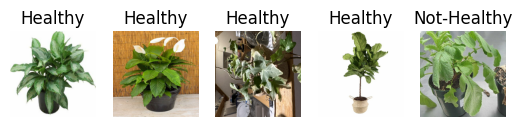

In [35]:

dataset = tf.keras.preprocessing.image_dataset_from_directory("../Houseplant_Photos",
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    shuffle=True)



class_names = dataset.class_names

first_batch = dataset.take(1)

for images, labels in first_batch:
    # Convert the batch to NumPy arrays
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    # Print the data type
    print(numpy_images.dtype, numpy_labels.dtype)
    # Print the array shape
    print(numpy_images.shape, numpy_labels.shape)
    # Plot the images
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(numpy_images[i].astype('uint8'))
        plt.title(class_names[labels[i].numpy()])
        plt.axis('off')
    plt.show()
    

In [36]:

## Collecting only the images for building GAN model
images = []
for image_batch, labels in dataset:
    
    # Convert the images to NumPy arrays
    images.extend(image_batch.numpy())
    
# shape of images
images = np.array(images)
print(images.shape)



2023-10-25 14:48:24.614127: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 703 of 1024
2023-10-25 14:48:28.503118: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


(1014, 256, 256, 3)


In [37]:
def preprocess_image(image):
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = (image) / 255.0
    return image

In [38]:
# Create a dataset of tensors and preprocess them
images_dataset = tf.data.Dataset.from_tensor_slices(images)
images_dataset = images_dataset.map(preprocess_image)
images_dataset = images_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)
images_dataset = images_dataset.prefetch(32)
images_dataset = images_dataset.cache()




In [39]:
images_dataset.as_numpy_iterator().next().shape

2023-10-25 14:48:31.373767: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(128, 256, 256, 3)

## Build Neural Network


1. import modeling components

In [40]:
# Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
# Bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D
from tensorflow.keras.layers.experimental.preprocessing import Resizing, Rescaling

In [41]:
# Create the generator
def build_generator():
    model = Sequential()
    model.add(Dense(64*64*128, input_dim=128))
    model.add(Reshape((64, 64, 128)))
    # model.add(Resizing(256, 256))
    # model.add(Rescaling(1./255))
    model.add(UpSampling2D())
    model.add(Conv2D(256, kernel_size=5, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(UpSampling2D())
    model.add(Conv2D(256, kernel_size=4, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(3, kernel_size=4, padding='same', activation='tanh'))
    return model


In [42]:
generator = build_generator()

In [43]:
generator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 524288)            67633152  
_________________________________________________________________
reshape_1 (Reshape)          (None, 64, 64, 128)       0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 128, 128, 256)     819456    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 128, 128, 256)     0         
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 256, 256, 256)     0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 256, 256, 256)    

In [44]:
# prediction from generator
img = generator.predict(np.random.randn(4,128))
img

array([[[[ 9.57993791e-03,  6.28402049e-04,  4.39841766e-03],
         [ 1.08579434e-02,  1.00271776e-04,  4.28334577e-03],
         [ 1.57616604e-02,  2.00409791e-03,  2.63048452e-04],
         ...,
         [-4.30177711e-03,  5.82485599e-03, -5.28497342e-03],
         [-5.19320462e-03, -6.03547262e-04, -4.87319613e-03],
         [ 1.23894075e-04, -1.93076243e-03, -3.74045875e-03]],

        [[ 8.71288404e-03,  4.40806337e-03,  4.27101227e-03],
         [ 9.22523718e-03, -4.06698277e-03,  2.13763514e-03],
         [ 7.03816488e-03,  8.85474496e-03,  6.08433736e-03],
         ...,
         [-4.58990829e-03, -2.30956636e-03, -6.26553362e-03],
         [-7.68562965e-03, -3.30299139e-03, -8.71141255e-03],
         [-2.52081593e-03, -3.31629859e-03, -3.98712931e-03]],

        [[ 5.36265085e-03, -1.36891764e-03,  6.89523155e-03],
         [ 5.97287621e-03, -5.05858753e-03,  5.82514843e-03],
         [ 2.95145728e-04,  1.62388978e-03,  1.51439542e-02],
         ...,
         [ 8.02606903e-0

In [45]:
img_array = np.array(img[0])
# print(img_array)
print(img[3].shape)


(256, 256, 3)


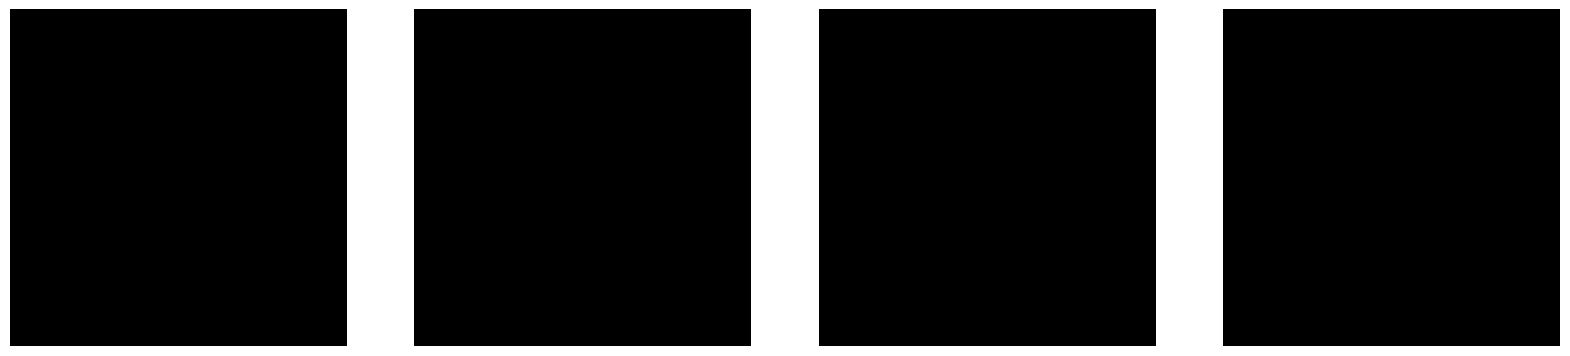

In [46]:
# plot the images
plt.figure(figsize=(20,20))
for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.imshow(img[i].astype('uint8'))
        plt.axis('off')
plt.show()

In [47]:
# create the discriminator
def build_discriminator():
    model = Sequential()
    # First Conv Block
    model.add(Conv2D(64, 5, input_shape=(256, 256, 3), padding='same')) # issue was here
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    # Second Conv Block
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    # Third Conv Block
    model.add(Conv2D(256, 5, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    # Flatten output and apply sigmoid
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

In [48]:
# build the discriminator
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 256, 256, 64)      4864      
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 256, 256, 64)      0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 256, 256, 128)     204928    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 256, 256, 128)     0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 256, 256, 128)     0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 256, 256, 256)    

In [51]:
img.shape
prediction = discriminator.predict(img)
prediction

array([[0.49942455],
       [0.49986148],
       [0.49951264],
       [0.4993351 ]], dtype=float32)

## Construct Training Loop

1. Setup Losses and Optimizers


In [52]:
# Adam is going to be the optimizer for both
from tensorflow.keras.optimizers import Adam
# Binary cross entropy is going to be the loss for both 
from tensorflow.keras.losses import BinaryCrossentropy

In [ ]:
g_opt = Adam(learning_rate=0.0001) 
d_opt = Adam(learning_rate=0.00001) 
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

2. Create the training class
